# transformer 번역기 프로젝트

## 프로젝트 목표

1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다.	
- 데이터 정제, SentencePiece를 활용한 토큰화 및 데이터셋 구축의 과정이 지시대로 진행되었다.
2. Transformer 번역기 모델이 정상적으로 구동된다.	
- Transformer 모델의 학습과 추론 과정이 정상적으로 진행되어, 한-영 번역기능이 정상 동작한다.
3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.	
- 제시된 문장에 대한 그럴듯한 영어 번역문이 생성되며, 시각화된 Attention Map으로 결과를 뒷받침한다.

## 코드구현

In [61]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import random

import sentencepiece as spm
from tqdm import tqdm 

### 데이터 전처리

In [62]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    cleaned_corpus = set(zip(kor, eng))

    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)
print(list(cleaned_corpus)[0])

('라라는 또한 멕시코 기자의 죽음에 대해 베네수엘라를 비판하는 멕시코의 시위와 베네수엘라 내부 반 차베스 시위대의 시위를 여과 없이 방영한 CNN을 비난했다.', 'Lara also criticized U.S.-based CNN for broadcasting video showing anti-government demonstrations, followed by images from Acapulco, Mexico, that showed protests against the death of a Mexican journalist and for juxtaposing Chavez with footage showing the body of an alleged al Qaeda leader and protests in China.')


In [63]:
def preprocess_sentence(sentence):
    
    # 소문자 변환
    sentence = sentence.lower().strip()

    # 알파벳, 문장부호, 한글만 남기기
    # 문장부호 양 옆에 공백 추가하기
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^가-힣a-zA-Z0-9?.!,]+", " ", sentence)    
    
    # 문장 앞뒤 공백제거
    sentence = sentence.strip()

    return sentence

In [64]:


# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):

    mode = "unigram" # BPE 도 됨
    model_prefix = f"{lang}_tokenizer_{vocab_size}_{mode}"
    input_file = f"{model_prefix}_train.txt"
    
    # 한글, 영어 구분
    if lang == "ko":
        lang_num = 1.0
    else:
        lang_num = 0.9995

    # 코퍼스 파일 저장
    with open(input_file, 'w', encoding='utf-8-sig') as f:
        for line in corpus:
            cleaned_line = line.strip()
            if cleaned_line:
                f.write(cleaned_line + '\n')

    # 토크나이저 학습
    spm.SentencePieceTrainer.train(
        input=input_file,
        model_prefix=model_prefix,
        vocab_size=vocab_size,
        pad_id=pad_id,
        bos_id=bos_id,
        eos_id=eos_id,
        unk_id=unk_id,
        character_coverage=lang_num,
        model_type=mode
    )

    # 토크나이저 로드
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.load(f"{model_prefix}.model")

    return tokenizer
    

SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for k, e in cleaned_corpus:
    # k, e = pair.split("\t")

    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ko_tokenizer_20000_unigram_train.txt
  input_format: 
  model_prefix: ko_tokenizer_20000_unigram
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
}
normalizer_spec {
  name: nmt_nfkc
  add_dummy_prefix: 1
  r

True

gram_model_trainer.cc(139) LOG(INFO) Making suffix array...
unigram_model_trainer.cc(143) LOG(INFO) Extracting frequent sub strings...
unigram_model_trainer.cc(194) LOG(INFO) Initialized 83783 seed sentencepieces
trainer_interface.cc(526) LOG(INFO) Tokenizing input sentences with whitespace: 78957
trainer_interface.cc(537) LOG(INFO) Done! 46275
unigram_model_trainer.cc(489) LOG(INFO) Using 46275 sentences for EM training
unigram_model_trainer.cc(505) LOG(INFO) EM sub_iter=0 size=35194 obj=9.97208 num_tokens=87100 num_tokens/piece=2.47485
unigram_model_trainer.cc(505) LOG(INFO) EM sub_iter=1 size=26446 obj=8.1277 num_tokens=87543 num_tokens/piece=3.31025
unigram_model_trainer.cc(505) LOG(INFO) EM sub_iter=0 size=21986 obj=8.04698 num_tokens=88961 num_tokens/piece=4.04626
unigram_model_trainer.cc(505) LOG(INFO) EM sub_iter=1 size=21887 obj=8.02745 num_tokens=89134 num_tokens/piece=4.07246
trainer_interface.cc(615) LOG(INFO) Saving model: en_tokenizer_20000_unigram.model
trainer_interface

In [65]:
print(len(kor_corpus), len(eng_corpus))

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
    # 각각 토크나이저로 인덱스
    src_line = ko_tokenizer.encode_as_ids(kor_corpus[idx])
    tgt_line = en_tokenizer.encode_as_ids(eng_corpus[idx])

    # 길이 필터링(50이하)
    if len(src_line) <=50 and len(tgt_line) <=50:
        src_corpus.append(src_line)
        tgt_corpus.append(tgt_line)  

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

print(len(enc_train), len(dec_train))

78968 78968


100%|██████████| 78968/78968 [00:05<00:00, 14922.25it/s]


71276 71276


### 모델설계

In [66]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

In [67]:
# class MultiHeadAttention(tf.keras.layers.Layer):
#     def __init__(self, d_model, num_heads):
#         super(MultiHeadAttention, self).__init__()
#         self.num_heads = num_heads
#         self.d_model = d_model

#         self.depth = d_model // self.num_heads

#         self.W_q = tf.keras.layers.Dense(d_model)
#         self.W_k = tf.keras.layers.Dense(d_model)
#         self.W_v = tf.keras.layers.Dense(d_model)

#         self.linear = tf.keras.layers.Dense(d_model)

#     def scaled_dot_product_attention(self, Q, K, V, mask):
#         d_k = tf.cast(K.shape[-1], tf.float32)
#         QK = tf.matmul(Q, K, transpose_b=True)

#         scaled_qk = QK / tf.math.sqrt(d_k)

#         if mask is not None: scaled_qk += (mask * -1e9)

#         attentions = tf.nn.softmax(scaled_qk, axis=-1)
#         out = tf.matmul(attentions, V)

#         return out, attentions


#     def split_heads(self, x):
# #         batch_size = x.shape[0]
#         batch_size = tf.shape(x)[0]
#         seq_len = tf.shape(x)[1]
#         split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
#         split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

#         return split_x

#     def combine_heads(self, x):
# #         batch_size = x.shape[0]
#         batch_size = tf.shape(x)[0]
#         seq_len = tf.shape(x)[2]
#         combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
#         combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

#         return combined_x


#     def call(self, Q, K, V, mask):
#         WQ = self.W_q(Q)
#         WK = self.W_k(K)
#         WV = self.W_v(V)

#         WQ_splits = self.split_heads(WQ)
#         WK_splits = self.split_heads(WK)
#         WV_splits = self.split_heads(WV)

#         out, attention_weights = self.scaled_dot_product_attention(
#             WQ_splits, WK_splits, WV_splits, mask)

#         out = self.combine_heads(out)
#         out = self.linear(out)

#         return out, attention_weights

In [68]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.depth = d_model // num_heads

        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(tf.shape(K)[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)  # (..., seq_len_q, seq_len_k)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None:
            # mask shape: (batch_size, num_heads, seq_len_q, seq_len_k)
            scaled_qk += (mask * -1e9)

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions

    def split_heads(self, x):
        batch_size = tf.shape(x)[0]
        seq_len = tf.shape(x)[1]

        # (batch_size, seq_len, num_heads, depth)
        split_x = tf.reshape(x, (batch_size, seq_len, self.num_heads, self.depth))

        # (batch_size, num_heads, seq_len, depth)
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = tf.shape(x)[0]
        seq_len = tf.shape(x)[2]

        # (batch_size, seq_len, num_heads, depth)
        x = tf.transpose(x, perm=[0, 2, 1, 3])

        # (batch_size, seq_len, d_model)
        combined_x = tf.reshape(x, (batch_size, seq_len, self.d_model))

        return combined_x

    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)  # (batch_size, seq_len_q, d_model)
        WK = self.W_k(K)  # (batch_size, seq_len_k, d_model)
        WV = self.W_v(V)  # (batch_size, seq_len_v, d_model)

        WQ_splits = self.split_heads(WQ)  # (batch_size, num_heads, seq_len_q, depth)
        WK_splits = self.split_heads(WK)  # (batch_size, num_heads, seq_len_k, depth)
        WV_splits = self.split_heads(WV)  # (batch_size, num_heads, seq_len_v, depth)

        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask
        )

        out = self.combine_heads(out)  # (batch_size, seq_len_q, d_model)
        out = self.linear(out)

        return out, attention_weights


In [69]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)

        return out

In [70]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, enc_attn

In [71]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, causality_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [72]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout)
                        for _ in range(n_layers)]

    def call(self, x, mask):
        out = x

        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)

        return out, enc_attns

In [73]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout)
                            for _ in range(n_layers)]


    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x

        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [89]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.n_heads = n_heads

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out


    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

### 모델 선언

In [90]:
D_MODEL = 512
transformer = Transformer(
                    n_layers=2,
                    d_model=D_MODEL,
                    n_heads=8,
                    d_ff=256,
                    src_vocab_size= SRC_VOCAB_SIZE,
                    tgt_vocab_size= TGT_VOCAB_SIZE,
                    pos_len = 50,
                    dropout=0.2,
                    shared=True)

In [91]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [92]:
learning_rate = CustomSchedule(d_model=D_MODEL)
optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


Text(0.5, 0, 'Train Step')

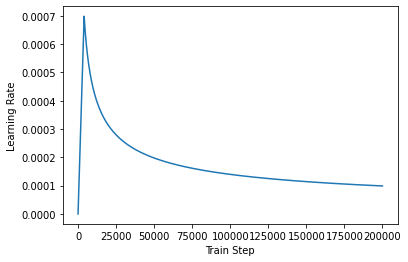

In [93]:
plt.plot(learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [94]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [95]:
# def generate_padding_mask(seq):
#     seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
#     return seq[:, tf.newaxis, tf.newaxis, :]

# def generate_causality_mask(size):
#     mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
#     return mask  # (seq_len, seq_len)

# def generate_masks(src, tgt):
#     enc_mask = generate_padding_mask(src)
#     dec_mask = generate_causality_mask(tf.shape(tgt)[1])
#     dec_enc_mask = generate_padding_mask(src)

#     return enc_mask, dec_enc_mask, dec_mask

In [103]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(seq_len, batch_size, num_heads):
    # 기본 Look-ahead Mask 생성
    mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)  # (seq_len, seq_len)

    # 4D로 변형 후 batch와 heads 차원에 맞게 타일링
    mask = mask[tf.newaxis, tf.newaxis, :, :]  # (1, 1, seq_len, seq_len)
    mask = tf.tile(mask, [batch_size, num_heads, 1, 1])  # (batch_size, num_heads, seq_len, seq_len)

    return mask


def generate_masks(src, tgt, batch_size=1, num_heads=8):
    enc_padding_mask = generate_padding_mask(src)
    dec_enc_padding_mask = generate_padding_mask(src)

    dec_padding_mask = generate_padding_mask(tgt)

    seq_len = tf.shape(tgt)[1]
    causal_mask = generate_causality_mask(seq_len, batch_size, num_heads)

    # Look-ahead + padding mask 결합
    combined_mask = tf.maximum(dec_padding_mask, causal_mask)

    return enc_padding_mask, dec_enc_padding_mask, combined_mask


In [96]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

In [97]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [105]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        batch_size = tf.shape(_input)[0]

        enc_padding_mask, dec_enc_padding_mask, combined_mask = \
            generate_masks(_input, output, batch_size=batch_size, num_heads=model.n_heads)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_enc_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [106]:

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [108]:
BATCH_SIZE = 64
EPOCHS = 3

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

for example in examples:
    translate(example, transformer, ko_tokenizer, en_tokenizer)

Epoch  3: 100%|██████████| 1114/1114 [02:43<00:00,  6.80it/s, Loss 0.3357]


Input: 오바마는 대통령이다.
Predicted translation: inginginginginginginginginginginginginginginginginginginginginginginginginginginginginginginginginginginginginginginginginginginginginginginginginging
Input: 시민들은 도시 속에 산다.
Predicted translation: area area area area area area area area area area area area area area area area area area area area area area area area area area area area area area area area area area area area area area area area area area area area area .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: very different city , said very differents , stronger told reuters at least three people .
